<h1 style="text-align: center;">Bayesian programming Project</h1>
<p style="text-align: center;">SUPSI 3rd year Bachelor DS&AI</p>
<p style="text-align: center;">Tommaso Sommaruga, Miro Rava</p>

### `Introduction`
Football is a global phenomenon, with numerous championships showcasing distinct playing styles, team dynamics, and competitive structures. In this project, we focus on analyzing the differences and similarities between two of the most prominent football leagues: Serie A (Italy) and the Premier League (England).

The dataset used for this analysis is sourced from https://www.football-data.co.uk, a comprehensive repository of football match statistics. Each row in the dataset represents a matchday within a specific season for each championship with its related betting odds. While the dataset includes data from various global leagues, we have narrowed our scope to the Italian Serie A and the English Premier League to provide focused insights.

This project is structured around several statistical tasks aimed at uncovering meaningful patterns and testing hypotheses within the data:
- Exploratory Data Analysis: A detailed examination of the dataset to understand its structure and uncover initial trends.
- Hypothesis Testing: For each student, a hypothesis test will be conducted using Bayesian methods, with prior sensitivity analysis, posterior probability calculations (using ROPE), and a comparison with a frequentist approach.
- Regression Analysis: Each student will build a regression model, perform posterior predictive checks, and generate predictive distributions for test-set observations.
- Hierarchical vs. Unpooled Models: The group will construct both hierarchical and unpooled models, with a focus on comparing predictions for a specific group and analyzing the posterior distribution of a novel group.

---

## Data source
The following sources which have been utilised in the compilation of Football-Data's results and odds files.


Current results (full time, half time)
XScores - http://www.xscores .com

Match statistics
BBC, ESPN Soccer, Bundesliga.de, Gazzetta.it and Football.fr

Bookmakers betting odds
Betbrain.com
Oddsportal.com
Individual bookmakers

Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.

### Dataset composition

In [1]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#data_folder = "data"

# Initialize lists for Premier League and Serie A datasets
#premier_league_files = [f for f in os.listdir(data_folder) if f.startswith("E0") and f.endswith(".csv")]
#serie_a_files = [f for f in os.listdir(data_folder) if f.startswith("I1") and f.endswith(".csv")]

#def load_and_combine(files, league_name):
#    combined_df = pd.DataFrame()
#    for file in files:
#        file_path = os.path.join(data_folder, file)
#        df = pd.read_csv(file_path)
#
#        # Extract season from the filename (e.g., 'E0_2023.csv' -> '2023')
#        season = file.split("_")[1].split(".")[0]
#        df["Season"] = season
#        df["League"] = league_name
#        combined_df = pd.concat([combined_df, df], ignore_index=True)
#    return combined_df

#premier_league_data = load_and_combine(premier_league_files, "Premier League")
#serie_a_data = load_and_combine(serie_a_files, "Serie A")

#all_data = pd.concat([premier_league_data, serie_a_data], ignore_index=True)#

#display(all_data.head())

#all_data.to_csv("combined_league_data.csv", index=False)
#print("Combined dataset saved as 'combined_league_data.csv'.")


In [3]:
data = pd.read_csv('combined_league_data.csv')

# Split data by league and season
serie_a_data = data[data['League'] == 'Serie A']
pl_data = data[data['League'] == 'Premier League']

display(serie_a_data.head())
display(pl_data.head())

C:\Users\miror\AppData\Local\Temp\ipykernel_20036\1491448300.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('combined_league_data.csv')


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
3040,I1,24/08/2019,17:00,Parma,Juventus,0,1,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3041,I1,24/08/2019,19:45,Fiorentina,Napoli,3,4,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3042,I1,25/08/2019,17:00,Udinese,Milan,1,0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3043,I1,25/08/2019,19:45,Cagliari,Brescia,0,1,A,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3044,I1,25/08/2019,19:45,Roma,Genoa,3,3,D,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
serie_a_data.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'LBH', 'LBD', 'LBA'],
      dtype='object', length=129)

---

## Data cleaning

In [5]:
serie_a_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 3040 to 6079
Columns: 129 entries, Div to LBA
dtypes: float64(105), int64(15), object(9)
memory usage: 3.0+ MB


In [6]:
pl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 0 to 3039
Columns: 129 entries, Div to LBA
dtypes: float64(105), int64(15), object(9)
memory usage: 3.0+ MB


In [7]:
data[data['Time'].isnull()]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
380,E0,10/08/2018,NaN,Man United,Leicester,2,1,H,1.0,0.0,...,1.79,17.0,-0.75,1.75,1.70,2.29,2.21,NaN,NaN,NaN
381,E0,11/08/2018,NaN,Bournemouth,Cardiff,2,0,H,1.0,0.0,...,1.83,20.0,-0.75,2.20,2.13,1.80,1.75,NaN,NaN,NaN
382,E0,11/08/2018,NaN,Fulham,Crystal Palace,0,2,A,0.0,1.0,...,1.87,22.0,-0.25,2.18,2.11,1.81,1.77,NaN,NaN,NaN
383,E0,11/08/2018,NaN,Huddersfield,Chelsea,0,3,A,0.0,2.0,...,1.84,23.0,1.00,1.84,1.80,2.13,2.06,NaN,NaN,NaN
384,E0,11/08/2018,NaN,Newcastle,Tottenham,1,2,A,1.0,2.0,...,1.81,20.0,0.25,2.20,2.12,1.80,1.76,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,I1,20/05/18,NaN,Milan,Fiorentina,5,1,H,2.0,1.0,...,2.35,18.0,-0.75,2.11,2.03,1.86,1.81,1.80,3.80,4.00
6076,I1,20/05/18,NaN,Napoli,Crotone,2,1,H,2.0,0.0,...,2.78,19.0,-1.25,2.00,1.96,1.94,1.89,1.44,4.60,6.50
6077,I1,20/05/18,NaN,Sassuolo,Roma,0,1,A,0.0,1.0,...,2.57,18.0,0.50,2.06,2.01,1.89,1.85,3.80,3.80,1.85
6078,I1,20/05/18,NaN,Spal,Sampdoria,3,1,H,1.0,0.0,...,2.18,20.0,-1.00,2.13,2.06,1.84,1.80,1.61,4.00,5.20


In [8]:
nan_data = data.columns[data.isna().sum() > 400]
nan_data

Index(['Time', 'Referee', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA',
       'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5',
       'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA',
       'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA',
       'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA',
       'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD',
       'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5',
       'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA',
       'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'Bb1X2',
       'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU',
       'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh',
       'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'LBH', 'LBD', 'LBA'],
      dtype='object')

In [9]:
columns_to_drop = [
    'Time', 'Referee', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5',
    'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA',
    'Bb1X2', 'BbOU', 'BbAH', 'AHh', 'AHCh',
    'B365CH', 'BWCH', 'IWCH', 'WHCH', 'VCCH',
    'B365C>2.5', 'PC>2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5'
]
data = data.drop(columns=columns_to_drop)


In [10]:
# Define bookmaker-specific columns for home, draw, and away odds
home_odds_columns = ['B365H', 'BFH', 'BSH', 'BWH', 'GBH', 'IWH', 'LBH', 'PSH', 'SOH', 'SBH', 'SJH', 'SYH', 'VCH', 'WHH']
draw_odds_columns = ['B365D', 'BFD', 'BSD', 'BWD', 'GBD', 'IWD', 'LBD', 'PSD', 'SOD', 'SBD', 'SJD', 'SYD', 'VCD', 'WHD']
away_odds_columns = ['B365A', 'BFA', 'BSA', 'BWA', 'GBA', 'IWA', 'LBA', 'PSA', 'SOA', 'SBA', 'SJA', 'SYA', 'VCA', 'WHA']

# Function to impute or derive maximum and average odds
def impute_or_derive_odds(data, max_col, avg_col, odds_columns):
    # Filter available odds columns
    available_odds = [col for col in odds_columns if col in data.columns]

    if not available_odds:
        raise ValueError(f"No bookmaker columns available to impute or derive {max_col} and {avg_col}.")

    # Impute missing values in available odds columns
    for col in available_odds:
        data[col] = data[col].fillna(data.groupby('Div')[col].transform('mean'))
        data[col] = data[col].ffill().bfill()

    # Derive Max and Avg odds
    data[max_col] = data[max_col].fillna(data[available_odds].max(axis=1))
    data[avg_col] = data[avg_col].fillna(data[available_odds].mean(axis=1))

# Impute or derive odds for home, draw, and away
impute_or_derive_odds(data, 'MaxH', 'AvgH', home_odds_columns)
impute_or_derive_odds(data, 'MaxD', 'AvgD', draw_odds_columns)
impute_or_derive_odds(data, 'MaxA', 'AvgA', away_odds_columns)

# Verify if there are any remaining NaN values in the critical columns
remaining_nans = data[['MaxH', 'AvgH', 'MaxD', 'AvgD', 'MaxA', 'AvgA']].isna().sum()
print("Remaining NaN values after imputation:")
print(remaining_nans)

Remaining NaN values after imputation:
MaxH    0
AvgH    0
MaxD    0
AvgD    0
MaxA    0
AvgA    0
dtype: int64


In [11]:
data.isna().sum()

Div            0
Date           0
HomeTeam       0
AwayTeam       0
FTHG           0
            ... 
BbMxAHA     3800
BbAvAHA     3800
LBH            0
LBD            0
LBA            0
Length: 101, dtype: int64

In [12]:
nan_cols = data.columns[(data.isna().sum() < 3) & (data.isna().sum() > 0)]
nan_cols

Index(['HTHG', 'HTAG', 'HTR'], dtype='object')

In [13]:
data[data['BWH'].isnull()]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMx<2.5,BbAv<2.5,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA


In [14]:
data[data['B365H'].isnull()]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMx<2.5,BbAv<2.5,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA


Cannot impute so, drop rows

In [15]:
odds_home = data['B365H'].values
data.loc[:, 'HomeWin'] = (data['FTR'] == 'H').astype(int)
home_win = data['HomeWin'].values

In [16]:
nan_data = data.columns[data.isna().sum() > 400]
nan_data

Index(['B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'B365AHH', 'B365AHA', 'PAHH',
       'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CD', 'B365CA',
       'BWCD', 'BWCA', 'IWCD', 'IWCA', 'WHCD', 'WHCA', 'VCCD', 'VCCA',
       'B365C<2.5', 'PC<2.5', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA',
       'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA'],
      dtype='object')

In [17]:
data = data.drop(columns=nan_data)

In [18]:
nan_cols = data.columns[data.isna().sum() > 0]
data[data[nan_cols].isnull().any(axis=1)]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
5337,I1,28/08/16,Sassuolo,Pescara,0,3,A,NaN,NaN,NaN,...,5.854286,1.66,4.0,5.99,2016,Serie A,1.62,3.75,5.75,0


This game had a result of 2-1 for Sassuolo.
The match was then awarded to Pescara by default, as the opposing team fielded a player who was not properly registered.

In [19]:
match_condition = (data['HomeTeam'] == 'Sassuolo') & (data['AwayTeam'] == 'Pescara')

data.loc[match_condition, 'FTHG'] = 2
data.loc[match_condition, 'FTAG'] = 1
data.loc[match_condition, 'FTR'] = 'H'
data.loc[match_condition, 'HTHG'] = 1
data.loc[match_condition, 'HTAG'] = 0
data.loc[match_condition, 'HTR'] = 'H'

print(data.loc[match_condition, ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR']])


      HomeTeam AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR
5337  Sassuolo  Pescara     2     1   H   1.0   0.0   H


In [20]:
#data.to_csv("cleaned_football_data.csv", index=False)

In [21]:
# General info about the dataset
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Div       6080 non-null   object 
 1   Date      6080 non-null   object 
 2   HomeTeam  6080 non-null   object 
 3   AwayTeam  6080 non-null   object 
 4   FTHG      6080 non-null   int64  
 5   FTAG      6080 non-null   int64  
 6   FTR       6080 non-null   object 
 7   HTHG      6080 non-null   float64
 8   HTAG      6080 non-null   float64
 9   HTR       6080 non-null   object 
 10  HS        6080 non-null   int64  
 11  AS        6080 non-null   int64  
 12  HST       6080 non-null   int64  
 13  AST       6080 non-null   int64  
 14  HF        6080 non-null   int64  
 15  AF        6080 non-null   int64  
 16  HC        6080 non-null   int64  
 17  AC        6080 non-null   int64  
 18  HY        6080 non-null   int64  
 19  AY        6080 non-null   int64  
 20  HR        6080 non-null   int6

In [22]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

Div         0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
B365H       0
B365D       0
B365A       0
BWH         0
BWD         0
BWA         0
IWH         0
IWD         0
IWA         0
PSH         0
PSD         0
PSA         0
WHH         0
WHD         0
WHA         0
VCH         0
VCD         0
VCA         0
MaxH        0
MaxD        0
MaxA        0
AvgH        0
AvgD        0
AvgA        0
PSCH        0
PSCD        0
PSCA        0
Season      0
League      0
LBH         0
LBD         0
LBA         0
HomeWin     0
dtype: int64

In [23]:
# Summary statistics for numeric columns
data.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AvgD,AvgA,PSCH,PSCD,PSCA,Season,LBH,LBD,LBA,HomeWin
count,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,...,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000
mean,1.544737,1.274507,0.679441,0.559704,13.487007,11.194901,4.977632,4.170559,11.770888,12.027467,...,4.171547,4.696887,3.063176,4.296352,4.949477,2019.500000,2.916204,4.097605,5.173974,0.439803
std,1.303054,1.196643,0.836948,0.764865,5.582458,4.894714,2.725259,2.454258,3.875506,4.032122,...,1.240645,4.034292,2.328604,1.498489,4.576159,2.291476,1.103505,0.637870,2.489419,0.496404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.645103,1.150000,1.040000,2.730000,1.090000,2016.000000,1.060000,2.900000,1.150000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,8.000000,3.000000,2.000000,9.000000,9.000000,...,3.420000,2.250000,1.660000,3.430000,2.240000,2017.750000,2.878750,4.095724,5.155421,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,5.000000,4.000000,12.000000,12.000000,...,3.730000,3.311429,2.310000,3.770000,3.400000,2019.500000,2.878750,4.095724,5.155421,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,7.000000,6.000000,14.000000,15.000000,...,4.422399,5.440000,3.480000,4.550000,5.682500,2021.250000,2.953658,4.099487,5.192526,1.000000
max,9.000000,9.000000,5.000000,5.000000,46.000000,31.000000,18.000000,16.000000,28.000000,32.000000,...,15.142857,38.714286,25.830000,18.500000,50.000000,2023.000000,17.000000,15.000000,51.000000,1.000000


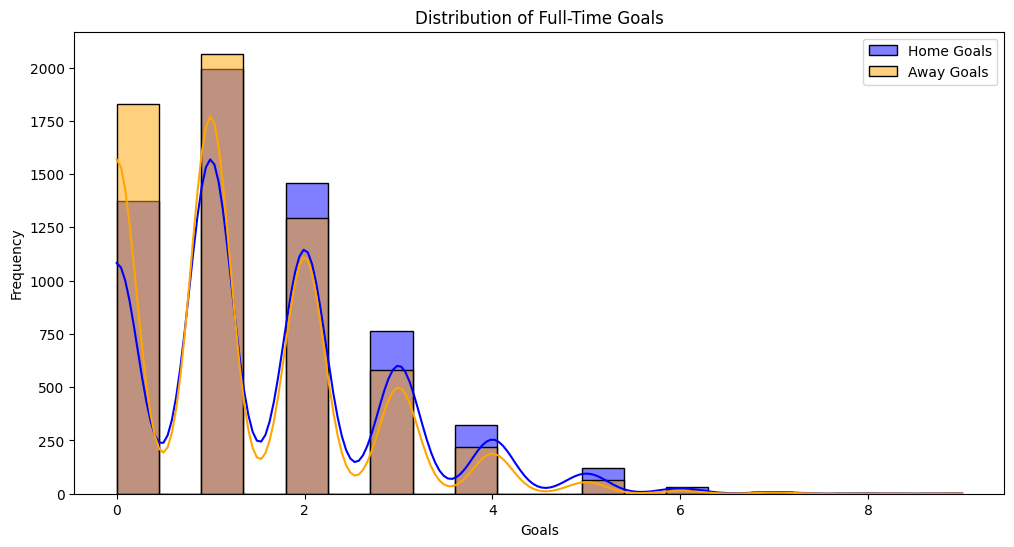

In [27]:
# Visualizing distributions: Full-time goals scored by home and away teams
plt.figure(figsize=(12, 6))
sns.histplot(data['FTHG'], kde=True, bins=20, color='blue', label='Home Goals')
sns.histplot(data['FTAG'], kde=True, bins=20, color='orange', label='Away Goals')
plt.title('Distribution of Full-Time Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

C:\Users\miror\AppData\Local\Temp\ipykernel_20036\3533490146.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FTR', data=data, palette='viridis', order=['H', 'D', 'A'])


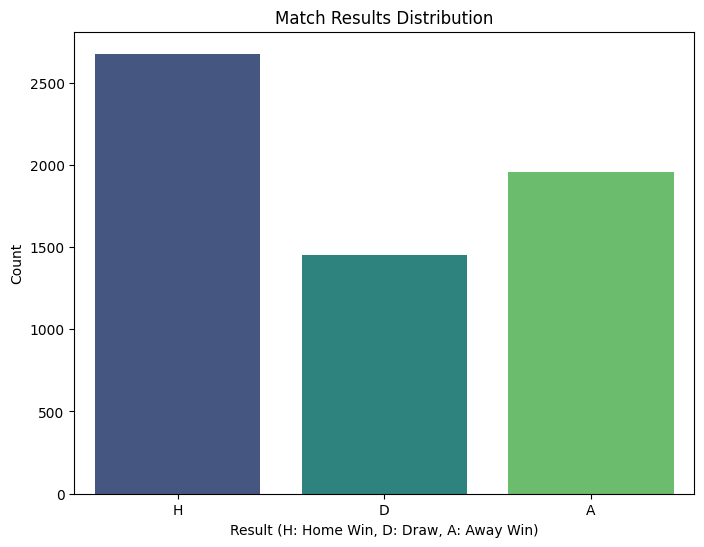

In [25]:
# Visualizing match results distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='FTR', data=data, palette='viridis', order=['H', 'D', 'A'])
plt.title('Match Results Distribution')
plt.xlabel('Result (H: Home Win, D: Draw, A: Away Win)')
plt.ylabel('Count')
plt.show()

## Hypothesis test `1`
### see notebook click --> [HYPOTHESIS 1](1_Hypothesis_test_1.ipynb) <--

## Hypothesis test `2`
### see notebook click --> [HYPOTHESIS 2](2_Hypothesis_test_2.ipynb) <--

## Regression `1`: 
### see notebook click --> [REGRESSION 1](3_Regression_1.ipynb) <--

## Regression `2`: 
### see notebook click --> [REGRESSION 2](4_regression_2.ipynb) <--

## Unpooled, Hierarchical: 
### see notebook click --> [Unpooled, Hierarchical](5_unpooled_hierarchical.ipynb) <--